In [43]:
import numpy as np 
from scipy.stats import norm
from math import log, sqrt, exp
import matplotlib.pyplot as plt


In [82]:
def bs_call_price(S, K, r, sigma, t, T):
    """
    Black–Scholes formula for a European call option.
    S: current underlying price
    K: strike
    r: risk-free rate
    sigma: volatility
    t: current time
    T: maturity time
    """
    tau = T - t  # time to maturity
    if tau <= 0:
        return max(S - K, 0)  # option payoff at/after maturity
    
    d1 = (log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*sqrt(tau))
    d2 = d1 - sigma*sqrt(tau)
    
    call = S*norm.cdf(d1) - K*exp(-r*tau)*norm.cdf(d2)
    return call

def bs_call_delta(S, K, r, sigma, t, T):
    """
    Delta for a European call option (partial derivative of price wrt S).
    """
    tau = T - t
    if tau <= 0:
        
        return (S>K)* 1.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)


In [117]:

# ------------------------------
# Parameters for the simulation
# ------------------------------
S0 = 100.0      # initial underlying price
K  = 100.0      # strike
r  = 0.02       # annual risk-free rate
sigma = 0.20    # volatility (20%)
T  = 1.0        # maturity in years (1 year)
steps = 1000      # number of discrete hedging steps
dt = T / steps  # length of each time step
nb_simul = 10000



 ...]

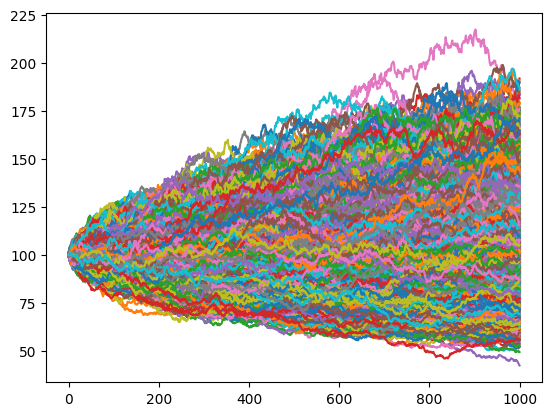

In [118]:
#Simulated path 
times = np.linspace(0, T, steps+1)
Z = np.random.normal(0,1,(nb_simul,steps+1))
Z = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
Z[:,0]=S0
Z = Z.cumprod(axis = 1)
plt.plot(Z.T)

mean -0.002239897926442678 std 0.2210982779488199


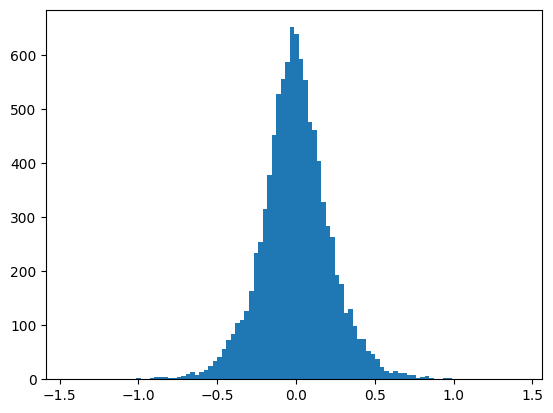

In [120]:
"""
# ----------------------
# Delta-hedging
# ----------------------
# We SELL 1 call option at t=0, so we get its premium initially.
premium = bs_call_price(S0, K, r, sigma, 0.0, T)"""

# Our hedge: we hold Delta shares of the underlying (continuously updated).
# Start: compute initial delta at t=0
delta_old = bs_call_delta(S0, K, r, sigma, 0.0, T)
premium = bs_call_price(S0, K, r, sigma, 0.0, T)
# We'll track the value of our hedging portfolio:
#   - "option value" is negative (we sold the call).
#   - "stock holding" is delta shares.
#   - "cash" starts with the option premium minus the cost to buy delta shares.
portfolio_value = premium - delta_old*S0
# To keep track of PnL, note that at each step we:
#  - Revalue the option
#  - Rebalance the hedge (update delta)
#  - Gains/losses go into portfolio_value
for i in range(1, steps+1):
    t = times[i]
    # New delta
    delta_new = bs_call_delta(Z[:,i], K, r, sigma, t, T)
    
    # Rebalance cost: We go from delta_old shares to delta_new shares.
    # The price of the shares is S[i]. 
    # So the immediate cashflow from rebalancing is: (delta_old - delta_new)*S[i]
    # (If delta_new > delta_old, we are buying shares, so we spend money (negative).)
    rebalance_cashflow = (delta_old - delta_new)*Z[:,i]
    
    # Update portfolio value by that cashflow
    portfolio_value += rebalance_cashflow
    # Move forward in time: accrue risk-free interest over dt
    # (Very rough discrete approximation: portfolio_value *= exp(r*dt))
    # We'll do that only if we want to incorporate interest on any cash part:
    portfolio_value *= exp(r*dt)
    
    # Update old delta
    delta_old = delta_new

# ---------------------------
# Final payout of the option
# ---------------------------
# At maturity, the call option we sold costs us: payoff = max(S(T) - K, 0).
final_option_payoff = (Z[:,-1]-K >0)*(Z[:,-1]-K)

# The final stock holding is delta_old shares worth delta_old * S[-1].
# We can liquidate them at maturity. So the final net in the portfolio is:
final_portfolio_value = portfolio_value + delta_old * Z[:,-1] - final_option_payoff

plt.hist(final_portfolio_value,bins =100)
print('mean', final_portfolio_value.mean(),'std', final_portfolio_value.std())

# Make the plot for delta for different time to maturity and different stike 